# Time Series Prediction with Knowledge Based Deep Learning (KdL)



## Libraries

In [119]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Loading Datasets

In [120]:
#El NINO dataset

data = pd.read_csv("datasets/elnino.csv")#, sep = ";")
training_set = data.iloc[:,1]#.reset_index(drop=True)#.set_index("Time(norwegian mean time)")
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


In [112]:
#San JUAN dataset
data = pd.read_csv("datasets/sanjuan.csv")#, sep = ";")
training_set = data.iloc[:,3]#.reset_index(drop=True)#.set_index("Time(norwegian mean time)")
training_set.shape

(1196,)

In [113]:
#Rainfall dataset
data = pd.read_csv("datasets/Rainfall.csv", sep = ";")
training_set = data.set_index("Time(norwegian mean time)")#
training_set = training_set.iloc[:,2]#.plot()
print(data.head)

<bound method NDFrame.head of            Name  Station Time(norwegian mean time)  Precipitation (24 h)
0      Bjørnøya  SN99710                16.06.1980                   0.0
1      Bjørnøya  SN99710                17.06.1980                   0.1
2      Bjørnøya  SN99710                18.06.1980                   0.0
3      Bjørnøya  SN99710                19.06.1980                   0.0
4      Bjørnøya  SN99710                20.06.1980                   1.9
...         ...      ...                       ...                   ...
15315  Bjørnøya  SN99710                11.06.2022                   0.0
15316  Bjørnøya  SN99710                12.06.2022                   0.0
15317  Bjørnøya  SN99710                13.06.2022                   0.0
15318  Bjørnøya  SN99710                15.06.2022                   0.0
15319  Bjørnøya  SN99710                16.06.2022                   0.0

[15320 rows x 4 columns]>


## Pretraining Dataset

In [114]:
# Lienard intermittancy
data = np.genfromtxt('datasets/lienard_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)#.iloc[0:50000,:]
training_set = training_set.iloc[:,1]

## Computing the Gradients

In [121]:
#y = training_set.iloc[:,0].reset_index(drop=True)
t_diff = 7
#print(t_diff)
#training_set = training_set.iloc[:,0].reset_index(drop=True)
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

29.2
1       0.000000
2       0.114286
3       0.028571
4       0.100000
5       0.100000
          ...   
1629   -0.242857
1630   -0.071429
1631    0.057143
1632   -0.085714
1633   -0.014286
Name: SST1, Length: 1633, dtype: float64
2       1.632653e-02
3      -1.224490e-02
4       1.020408e-02
5      -7.335402e-17
6      -1.224490e-02
            ...     
1629   -2.857143e-02
1630    2.448980e-02
1631    1.836735e-02
1632   -2.040816e-02
1633    1.020408e-02
Name: SST1, Length: 1632, dtype: float64


In [122]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
#training_set.squeeze()[:-1]
print(gradient_t)
print(gradient_tt)
# print(y[:-2].shape)
# print(x.iloc[:-2,:])

0       0.000000
1       0.114286
2       0.028571
3       0.100000
4       0.100000
          ...   
1628   -0.242857
1629   -0.071429
1630    0.057143
1631   -0.085714
1632   -0.014286
Name: SST1, Length: 1633, dtype: float64
0       1.632653e-02
1      -1.224490e-02
2       1.020408e-02
3      -7.335402e-17
4      -1.224490e-02
            ...     
1627   -2.857143e-02
1628    2.448980e-02
1629    1.836735e-02
1630   -2.040816e-02
1631    1.020408e-02
Name: SST1, Length: 1632, dtype: float64


In [123]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1],gradient_t), axis = 1)
#print(df[:-1])
gradient_tt.columns= ["grad_tt"]
#print(gradient_tt)
df = pd.concat((df[:-1],gradient_tt),axis = 1)

df.columns = ['y_t','grad_t','grad_tt']
#print(df)
#print(df)
#len(df)
#f_std = (f - f.min(axis=0)) / (f.max(axis=0) - f.min(axis=0))
#f = f_std

(1633,)
()


## Plot of the external forcing (from differential equation)

<AxesSubplot:>

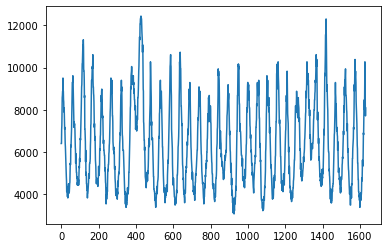

In [124]:
a = 0.45
b = 0.5#1.0
c = -0.5#-1.68
L = df.iloc[:,2] + a*df.iloc[:,0]*df.iloc[:,1] +c*df.iloc[:,0] +b* df.iloc[:,0]**3
#L = hampel(L, window_size=10, n=3, imputation=True)
#df.iloc[:,0].plot()
L.plot()

## Preprocessing the data into supervised learning

In [125]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup

data = Supervised(df.values, n_in = 10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:,-3:]
x = data[:,:-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        23.4       23.4       24.2       24.4       25.1       25.8   
11        23.4       24.2       24.4       25.1       25.8       25.9   
12        24.2       24.4       25.1       25.8       25.9       26.1   
13        24.4       25.1       25.8       25.9       26.1       26.1   
14        25.1       25.8       25.9       26.1       26.1       26.7   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10       25.9       26.1       26.1       26.7     26.1  0.000000 -0.008163  
11       26.1       26.1       26.7       26.1     26.1 -0.057143  0.006122  
12       26.1       26.7       26.1       26.1     25.7 -0.014286 -0.008163  
13       26.7       26.1       26.1       25.7     25.6 -0.071429  0.014286  
14       26.1       26.1       25.7       25.6     25.1  0.028571 -0.008163  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [131]:
#print(x)
train_size = int(len(y) * 0.8)
#print(len(y))
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
#print(trainY.shape)
#trainf = Variable(torch.Tensor(np.array(f[0:train_size])))
#trainf = trainf.reshape(trainf.shape[0],1)
#grad_t = torch.diff(trainY, dim = 0)
#grad_tt = torch.diff(grad_t, dim = 0)
#print(trainY.shape,grad_t.shape, grad_tt.shape)
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1297, 1, 10) (1297, 3) (325, 1, 10) (325, 3)


## Defining the physical loss

In [132]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def phys(y_pred, y_true):
    return mean_absolute_error(y_true[:,2] + a*y_true[:,0]*y_true[:,1] +c*y_true[:,0] +b* y_true[:,0]**3, y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] +a*y_pred[:-2]*(y_pred[1:-1]-y_pred[:-2]) +c*y_pred[:-2] +b* y_pred[:-2]**3
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] +a*y_real[:-2]*(y_real[1:-1]-y_real[:-2]) +c*y_real[:-2] +b* y_real[:-2]**3
    return(mean_absolute_error(pred,real))

## Model

In [ ]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:,0] - y_pred[:,0])
    squared_difference2 = tf.square(y_true[:,2]-y_pred[:,2])
    squared_difference1 = tf.square(y_true[:,1]-y_pred[:,1])    
    squared_difference3 = tf.square(y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
    #return tf.reduce_mean(squared_difference, axis=-1)+  tf.reduce_mean(squared_difference1, axis=-1)+  tf.reduce_mean(squared_difference2, axis=-1)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
    #return tf.reduce_mean(squared_difference, axis=-1) #+  tf.reduce_mean(squared_difference1, axis=-1)+  tf.reduce_mean(squared_difference2, axis=-1)
# design network
# #model = keras.models.load_model("alos.h5")
model = Sequential()
#model.add(LSTM(50,return_sequences = True, input_shape=(trainX.shape[1], trainX.shape[2]))) # return_sequences = True,
#model.add(LSTM(50,return_sequences = True, input_shape=(trainX.shape[1], trainX.shape[2]))) # return_sequences = True,
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]))) # return_sequences = True,
model.add(Dense(3))
# #model.load_weights("Lienard_0.2_LSTM")
model.compile(loss=loss_fn, optimizer='adam')
# # fit network
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=2, shuffle=False)
# # plot history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()
# model.save_weights("0.2_LSTM")#Rainfall_

Epoch 1/500
21/21 - 3s - loss: 0.1141 - val_loss: 0.0399 - 3s/epoch - 144ms/step
Epoch 2/500
21/21 - 0s - loss: 0.0207 - val_loss: 0.0176 - 237ms/epoch - 11ms/step
Epoch 3/500
21/21 - 0s - loss: 0.0161 - val_loss: 0.0152 - 158ms/epoch - 8ms/step
Epoch 4/500
21/21 - 0s - loss: 0.0138 - val_loss: 0.0138 - 161ms/epoch - 8ms/step
Epoch 5/500
21/21 - 0s - loss: 0.0124 - val_loss: 0.0121 - 177ms/epoch - 8ms/step
Epoch 6/500
21/21 - 0s - loss: 0.0109 - val_loss: 0.0106 - 180ms/epoch - 9ms/step
Epoch 7/500
21/21 - 0s - loss: 0.0095 - val_loss: 0.0091 - 221ms/epoch - 11ms/step
Epoch 8/500
21/21 - 0s - loss: 0.0081 - val_loss: 0.0077 - 188ms/epoch - 9ms/step
Epoch 9/500
21/21 - 0s - loss: 0.0068 - val_loss: 0.0064 - 160ms/epoch - 8ms/step
Epoch 10/500
21/21 - 0s - loss: 0.0056 - val_loss: 0.0052 - 184ms/epoch - 9ms/step
Epoch 11/500
21/21 - 0s - loss: 0.0045 - val_loss: 0.0043 - 159ms/epoch - 8ms/step
Epoch 12/500
21/21 - 0s - loss: 0.0037 - val_loss: 0.0035 - 156ms/epoch - 7ms/step
Epoch 13/500

Epoch 100/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 153ms/epoch - 7ms/step
Epoch 101/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 145ms/epoch - 7ms/step
Epoch 102/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 149ms/epoch - 7ms/step
Epoch 103/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 145ms/epoch - 7ms/step
Epoch 104/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 166ms/epoch - 8ms/step
Epoch 105/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 150ms/epoch - 7ms/step
Epoch 106/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 167ms/epoch - 8ms/step
Epoch 107/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0016 - 159ms/epoch - 8ms/step
Epoch 108/500
21/21 - 0s - loss: 0.0014 - val_loss: 0.0015 - 148ms/epoch - 7ms/step
Epoch 109/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0015 - 154ms/epoch - 7ms/step
Epoch 110/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0015 - 152ms/epoch - 7ms/step
Epoch 111/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0015 - 160ms/epoch - 8

Epoch 198/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 169ms/epoch - 8ms/step
Epoch 199/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 177ms/epoch - 8ms/step
Epoch 200/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 157ms/epoch - 7ms/step
Epoch 201/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 159ms/epoch - 8ms/step
Epoch 202/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 156ms/epoch - 7ms/step
Epoch 203/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 177ms/epoch - 8ms/step
Epoch 204/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 152ms/epoch - 7ms/step
Epoch 205/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 152ms/epoch - 7ms/step
Epoch 206/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 149ms/epoch - 7ms/step
Epoch 207/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 152ms/epoch - 7ms/step
Epoch 208/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 144ms/epoch - 7ms/step
Epoch 209/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 162ms/epoch - 8

Epoch 296/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 152ms/epoch - 7ms/step
Epoch 297/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 153ms/epoch - 7ms/step
Epoch 298/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 157ms/epoch - 7ms/step
Epoch 299/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 148ms/epoch - 7ms/step
Epoch 300/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 151ms/epoch - 7ms/step
Epoch 301/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 150ms/epoch - 7ms/step
Epoch 302/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 143ms/epoch - 7ms/step
Epoch 303/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 143ms/epoch - 7ms/step
Epoch 304/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 147ms/epoch - 7ms/step
Epoch 305/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 195ms/epoch - 9ms/step
Epoch 306/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 147ms/epoch - 7ms/step
Epoch 307/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 173ms/epoch - 8

Epoch 394/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 151ms/epoch - 7ms/step
Epoch 395/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 154ms/epoch - 7ms/step
Epoch 396/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 149ms/epoch - 7ms/step
Epoch 397/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 145ms/epoch - 7ms/step
Epoch 398/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 150ms/epoch - 7ms/step
Epoch 399/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 165ms/epoch - 8ms/step
Epoch 400/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 147ms/epoch - 7ms/step
Epoch 401/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 144ms/epoch - 7ms/step
Epoch 402/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 153ms/epoch - 7ms/step
Epoch 403/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 147ms/epoch - 7ms/step
Epoch 404/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 158ms/epoch - 8ms/step
Epoch 405/500
21/21 - 0s - loss: 0.0013 - val_loss: 0.0016 - 163ms/epoch - 8

## Prediction and accuracy

In [ ]:
...
#model.load_weights("Elnino_0.6_LSTM")
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make a prediction
#testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
yhat = model.predict(testX)

#yhat = yhat.reshape((len(yhat), 1))
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
# invert scaling for forecast
inv_yhat = np.concatenate((testX,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:,-3:]
inv_yhat = inv_yhat[:,-3]
# invert scaling for actual
#testY = testY.reshape((len(testY), 1))

inv_y = np.concatenate((testX,testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:,-3:]
inv_y = inv_y[:,-3]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse) 
print('Test MAE: %.3f' % mae)
print('Test Phys: %.3f' % phy)

## Plot of Test and Prediction

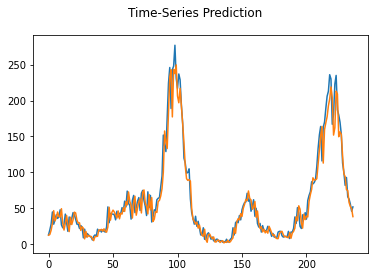

In [81]:
plt.plot(inv_y)#)[:,0]
plt.plot(inv_yhat)#)[:,0]
plt.suptitle('Time-Series Prediction')
plt.show()

In [133]:
# a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
# b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
# c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
# def loss_fn(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     squared_difference2 = tf.square(y_true[:,2] + a*y_true[:,0]*y_true[:,1] +c*y_true[:,0] +b* y_true[:,0]**3- y_pred[:,2] - a*y_pred[:,0]*y_pred[:,1] -c*y_pred[:,0] -b* y_pred[:,0]**3)
#     #squared_difference3 = tf.square(y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
#     return tf.reduce_mean(squared_difference, axis=-1) #+  0.2*tf.reduce_mean(squared_difference2, axis=-1)
# # design network
# # #model = keras.models.load_model("alos.h5")
# model = Sequential()
# model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]))) # return_sequences = True,
# model.add(Dense(3))
# # #model.load_weights("Lienard_0.2_LSTM")
# # model.compile(loss=loss_fn, optimizer='adam')
# # # fit network
# # history = model.fit(trainX, trainY, epochs=500, batch_size=256, validation_data=(testX, testY), verbose=2, shuffle=False)
# # # plot history
# # plt.plot(history.history['loss'], label='train')
# # plt.plot(history.history['val_loss'], label='test')
# # plt.legend()
# # plt.show()
# # model.save_weights("0.2_LSTM")#Rainfall_